In [11]:
import numpy as np
import cvxpy as cp

def cost_adjustment(A1, D2, global_min_position):
    """
    Adjusts the cost matrices to enforce potential function constraints through convex optimization.

    Parameters:
    - A1 (np.ndarray): Cost matrix for player 1.
    - D2 (np.ndarray): Cost matrix for player 2.
    - global_min_position (tuple[int, int]): Coordinates (row, column) of the desired global minimum.

    Returns:
    - np.ndarray: Adjusted error matrix E that satisfies the potential function conditions.
    """

    # Compute initial potential function
    phi_initial = potential_function(A1, D2, global_min_position)

    if is_valid_exact_potential(A1, D2, phi_initial) and \
            is_global_min_enforced(phi_initial, global_min_position):
        E = np.zeros_like(A1)
        return E

    # Convex optimization to find Ea
    m, n = A1.shape
    E = cp.Variable((m, n))
    phi = cp.Variable((m, n))
    A_prime = A1 + E
    constraints = []

    # Constraint 1: Ensure global minimum position is zero
    constraints.append(phi[global_min_position[0], global_min_position[1]] == 0)

    # Constraint 2: Enforce non-negativity
    epsilon = 1e-6
    for k in range(m):
        for j in range(n):
            if (k, j) != tuple(global_min_position):
                constraints.append(phi[k, j] >= epsilon)

    constraints += [
        A_prime[1:, :] - A_prime[:-1, :] == phi[1:, :] - phi[:-1, :],
        D2[:, 1:] - D2[:, :-1] == phi[:, 1:] - phi[:, :-1]
    ]

    # Solve optimization problem
    objective = cp.Minimize(cp.norm(E, 'fro'))
    problem = cp.Problem(objective, constraints)

    problem.solve(solver=cp.SCS, max_iters=50000, eps=1e-6, verbose=False)
    return E.value


def potential_function(A, B, global_min_position):
    """
    Computes a potential function for given cost matrices.

    Parameters:
    - A (np.ndarray): Cost matrix for player 1.
    - B (np.ndarray): Cost matrix for player 2.
    - global_min_position (tuple[int, int]): Coordinates (row, column) of the desired global minimum.

    Returns:
    - np.ndarray: Computed potential function matrix.
    """
    m, n = A.shape
    phi = np.zeros((m, n))

    for i in range(1, m):
        phi[i, 0] = phi[i - 1, 0] + A[i, 0] - A[i - 1, 0]

    for j in range(1, n):
        phi[0, j] = phi[0, j - 1] + B[0, j] - B[0, j - 1]

    for i in range(1, m):
        for j in range(1, n):
            phi[i, j] = (phi[i - 1, j] + A[i, j] - A[i - 1, j] +
                         phi[i, j - 1] + B[i, j] - B[i, j - 1]) / 2

    return phi - phi[global_min_position[0], global_min_position[1]]


def is_valid_exact_potential_old(A, B, phi):
    """
    Checks if the given potential function satisfies the exact potential condition.

    Parameters:
    - A (np.ndarray): Cost matrix for player 1.
    - B (np.ndarray): Cost matrix for player 2.
    - phi (np.ndarray): Potential function matrix.

    Returns:
    - bool: True if the exact potential condition is satisfied, False otherwise.
    """

    m, n = A.shape
    epsilon = 1e-6

    for i in range(1, m):
        for j in range(n):
            if not np.isclose((A[i, j] - A[i - 1, j]), (phi[i, j] - phi[i - 1, j]), atol=epsilon):
                return False

    for i in range(m):
        for j in range(1, n):
            if not np.isclose((B[i, j] - B[i, j-1]), (phi[i, j] - phi[i, j-1]), atol=epsilon):
                return False

    return True


def is_valid_exact_potential(A, B, phi, epsilon=1e-6):
    cond1 = np.allclose(A[1:, :] - A[:-1, :], phi[1:, :] - phi[:-1, :], atol=epsilon)
    cond2 = np.allclose(B[:, 1:] - B[:, :-1], phi[:, 1:] - phi[:, :-1], atol=epsilon)
    return cond1 and cond2


def is_global_min_enforced(phi, global_min_position):
    i, j = global_min_position
    if not np.isclose(phi[i, j], 0):
        return False
    mask = np.ones_like(phi, dtype=bool)
    mask[i, j] = False
    return np.all(phi[mask] > 0)


def find_adjusted_costs(A, B, pos1, pos2):
    """
    Determines the best cost adjustment matrix E using convex optimization.

    Parameters:
    - A1 (np.ndarray): Cost matrix for player 1.
    - B1 (np.ndarray): Cost matrix for player 1.
    - C1 (np.ndarray): Cost matrix for the second player's strategy.

    Returns:
    - np.ndarray: Adjusted cost matrix E, or None if no valid adjustment is found.
    """


    # find error matrices to make each combination of indices the global min of potential function
    E_star = np.ones_like(A) * np.inf
    min_position = (pos1, pos2)

    E = cost_adjustment(A, B, min_position)

    if E is not None:
        phi = potential_function(E + A, B, min_position)
        is_min = is_global_min_enforced(phi, min_position)
        is_exact = is_valid_exact_potential(A + E, B, phi)

        # print(is_min, is_exact)
        if is_min and is_exact and (np.linalg.norm(E) < np.linalg.norm(E_star)):

            player1_sec = np.argmin(np.max(A + E, axis=1))

            if min_position[0] == player1_sec:
                E_star = E


    return E_star

In [12]:
A = np.array([[1, 30],[0, 8]])
B = np.array([[2, 0],[30, 8]])

E = find_adjusted_costs(A, B, 1, 1)
print(E)

[[ 0.25000002 -0.24999998]
 [-0.25000002  0.24999998]]


In [47]:
import numpy as np
import cvxpy as cp

def cost_adjustment_multi_stopping(A1, D2, global_min_position):
    """
    Collects E matrices by solving with multiple stopping points.
    Returns list of all calculated E matrices.
    """
    all_E_matrices = []
    
    # Compute initial potential function
    phi_initial = potential_function(A1, D2, global_min_position)

    if is_valid_exact_potential(A1, D2, phi_initial) and \
            is_global_min_enforced(phi_initial, global_min_position):
        E = np.zeros_like(A1)
        all_E_matrices.append(E)
        return all_E_matrices

    # Setup optimization
    m, n = A1.shape
    E = cp.Variable((m, n))
    phi = cp.Variable((m, n))
    A_prime = A1 + E
    constraints = []

    # Constraints
    constraints.append(phi[global_min_position[0], global_min_position[1]] == 0)

    epsilon = 1e-6
    for k in range(m):
        for j in range(n):
            if (k, j) != tuple(global_min_position):
                constraints.append(phi[k, j] >= epsilon)

    constraints += [
        A_prime[1:, :] - A_prime[:-1, :] == phi[1:, :] - phi[:-1, :],
        D2[:, 1:] - D2[:, :-1] == phi[:, 1:] - phi[:, :-1]
    ]

    objective = cp.Minimize(cp.norm(E, 'fro'))
    problem = cp.Problem(objective, constraints)
    
    # Multiple stopping points
    stopping_points = [500, 1000, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 40000, 50000]
    
    for max_iter in stopping_points:
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-6, verbose=False, warm_start=True)

        # Mild slowdown
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-8, alpha=0.5, verbose=False, warm_start=True)

        # # Moderate slowdown  
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-10, alpha=0.3, rho_x=1e-8, verbose=False, warm_start=True)

        # # Aggressive slowdown
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-12, alpha=0.1, adaptive=False, verbose=False, warm_start=True)

        # # Maximum slowdown
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-15, alpha=0.05, rho_x=1e-10, sigma=1e-10, adaptive=False, acceleration_lookback=0, verbose=False, warm_start=True)

        # # Very tight tolerance
        # problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-14, verbose=False, warm_start=True)

        # # Small step size
        # problem.solve(solver=cp.SCS, max_iters=max_iter, alpha=0.01, verbose=False, warm_start=True)

        # # No acceleration
        # problem.solve(solver=cp.SCS, max_iters=max_iter, adaptive=False, acceleration_lookback=0, verbose=False, warm_start=True)

        # # Combined slow parameters
        problem.solve(solver=cp.SCS, max_iters=max_iter, eps=1e-12, alpha=0.05, rho_x=1e-9, cg_rate=0.1, verbose=False, warm_start=True)



        if E.value is not None:
            all_E_matrices.append(E.value.copy())
    
    return all_E_matrices


def find_adjusted_costs(A, B, pos1, pos2):
    # find error matrices to make each combination of indices the global min of potential function
    E_star = np.ones_like(A) * np.inf
    min_position = (pos1, pos2)

    E_lst = cost_adjustment_multi_stopping(A, B, min_position)

    if E_lst[-1] is not None:
        E = E_lst[-1]
        phi = potential_function(E + A, B, min_position)
        is_min = is_global_min_enforced(phi, min_position)
        is_exact = is_valid_exact_potential(A + E, B, phi)

        # print(is_min, is_exact)
        if is_min and is_exact and (np.linalg.norm(E) < np.linalg.norm(E_star)):
            E_star = E


    return E_star, E_lst

In [48]:
A = np.array([[2, 30],[0, 8]])

distortion = np.array([[9, -5],[3, -10]])
# distortion = np.array([[0.1, -0.5],[-0.9, -10]])
# distortion = np.array([[100.0, -99.9], [-0.1, 100.0]])

# Option 1: Near-singular (numerical challenges)
# distortion = np.array([[50.0, 50.001], [25.0, 25.0005]])

# Option 2: Large asymmetric (forces big corrections)
# distortion = np.array([[50, -25], [-15, 40]]) 

# Option 3: Maximally violates constraints
# distortion = np.array([[80, -60], [40, -90]])

A = A + distortion

B = np.array([[2, 0],[30, 8]])

E, E_lst = find_adjusted_costs(A, B, 1, 1)
print(E)

for E in E_lst:
    print()
    print(E)

ValueError: Error parsing inputs


In [25]:
import numpy as np

# Your original matrices
A_original = np.array([[2, 30],[0, 8]])
B = np.array([[2, 0],[30, 8]])

print("=== STRATEGY 1: Large Asymmetric Distortions ===")
# Create large asymmetric distortions that break potential function badly
distortion1 = np.array([[50, -25], [-15, 40]])
A1 = A_original + distortion1
print(f"Distortion 1:\n{distortion1}")
print(f"Resulting A1:\n{A1}")

print("\n=== STRATEGY 2: High Condition Number (Ill-conditioned) ===")
# Create a distortion that makes the problem ill-conditioned
distortion2 = np.array([[100, -99.9], [-0.1, 100]])
A2 = A_original + distortion2
print(f"Distortion 2:\n{distortion2}")
print(f"Resulting A2:\n{A2}")

print("\n=== STRATEGY 3: Oscillatory Pattern ===")
# Create alternating large/small values
distortion3 = np.array([[75, -75], [-75, 75]])
A3 = A_original + distortion3
print(f"Distortion 3:\n{distortion3}")
print(f"Resulting A3:\n{A3}")

print("\n=== STRATEGY 4: Scale-based Challenge ===")
# Large values with different scales
distortion4 = np.array([[200, 5], [0.01, -150]])
A4 = A_original + distortion4
print(f"Distortion 4:\n{distortion4}")
print(f"Resulting A4:\n{A4}")

print("\n=== STRATEGY 5: Random Large Distortion ===")
# Random but large distortion
np.random.seed(42)  # For reproducibility
distortion5 = np.random.uniform(-100, 100, (2, 2))
A5 = A_original + distortion5
print(f"Distortion 5:\n{distortion5}")
print(f"Resulting A5:\n{A5}")

print("\n=== STRATEGY 6: Maximize Constraint Violation ===")
# Design distortion to maximally violate potential function constraints
# This forces the optimizer to work harder to find corrections
distortion6 = np.array([[80, -60], [40, -90]])
A6 = A_original + distortion6
print(f"Distortion 6:\n{distortion6}")
print(f"Resulting A6:\n{A6}")

print("\n=== STRATEGY 7: Near-Singular Matrix ===")
# Create a distortion that makes A nearly singular (hard to invert)
distortion7 = np.array([[50.0, 50.001], [25.0, 25.0005]])
A7 = A_original + distortion7
print(f"Distortion 7:\n{distortion7}")
print(f"Resulting A7:\n{A7}")
print(f"Condition number of A7: {np.linalg.cond(A7):.2e}")

# Function to test convergence difficulty
def test_convergence_difficulty(A_test, B, name):
    """Quick test to see how 'difficult' the optimization will be"""
    print(f"\n--- Testing {name} ---")
    print(f"Matrix A:\n{A_test}")
    print(f"Condition number: {np.linalg.cond(A_test):.2e}")
    print(f"Frobenius norm: {np.linalg.norm(A_test, 'fro'):.2f}")
    
    # Check how far A deviates from B in structure
    diff_norm = np.linalg.norm(A_test - B, 'fro')
    print(f"||A - B||_F: {diff_norm:.2f}")
    
    # Estimate of optimization difficulty (heuristic)
    difficulty = np.linalg.cond(A_test) * diff_norm
    print(f"Difficulty estimate: {difficulty:.2e}")

# Test all distortions
test_cases = [
    (A1, "Large Asymmetric"),
    (A2, "Ill-conditioned"), 
    (A3, "Oscillatory"),
    (A4, "Multi-scale"),
    (A5, "Random Large"),
    (A6, "Max Violation"),
    (A7, "Near-singular")
]

print("\n" + "="*50)
print("CONVERGENCE DIFFICULTY ANALYSIS")
print("="*50)

for A_test, name in test_cases:
    test_convergence_difficulty(A_test, B, name)

print("\n" + "="*50)
print("RECOMMENDATIONS:")
print("="*50)
print("Try these distortions in order of likely success:")
print("1. Ill-conditioned (Strategy 2) - highest condition number")
print("2. Near-singular (Strategy 7) - creates numerical challenges") 
print("3. Max Violation (Strategy 6) - maximally breaks constraints")
print("4. Large Asymmetric (Strategy 1) - big corrections needed")

# Best candidate for slow convergence
print("\n" + "="*30)
print("RECOMMENDED DISTORTION:")
print("="*30)
best_distortion = distortion2  # Ill-conditioned case
A_best = A_original + best_distortion
print(f"distortion = np.array({best_distortion.tolist()})")
print(f"A = A_original + distortion")
print(f"# This gives A =")
print(f"# {A_best}")
print(f"# Condition number: {np.linalg.cond(A_best):.2e}")

=== STRATEGY 1: Large Asymmetric Distortions ===
Distortion 1:
[[ 50 -25]
 [-15  40]]
Resulting A1:
[[ 52   5]
 [-15  48]]

=== STRATEGY 2: High Condition Number (Ill-conditioned) ===
Distortion 2:
[[100.  -99.9]
 [ -0.1 100. ]]
Resulting A2:
[[ 1.02e+02 -6.99e+01]
 [-1.00e-01  1.08e+02]]

=== STRATEGY 3: Oscillatory Pattern ===
Distortion 3:
[[ 75 -75]
 [-75  75]]
Resulting A3:
[[ 77 -45]
 [-75  83]]

=== STRATEGY 4: Scale-based Challenge ===
Distortion 4:
[[ 2.0e+02  5.0e+00]
 [ 1.0e-02 -1.5e+02]]
Resulting A4:
[[ 2.02e+02  3.50e+01]
 [ 1.00e-02 -1.42e+02]]

=== STRATEGY 5: Random Large Distortion ===
Distortion 5:
[[-25.09197623  90.14286128]
 [ 46.39878836  19.73169684]]
Resulting A5:
[[-23.09197623 120.14286128]
 [ 46.39878836  27.73169684]]

=== STRATEGY 6: Maximize Constraint Violation ===
Distortion 6:
[[ 80 -60]
 [ 40 -90]]
Resulting A6:
[[ 82 -30]
 [ 40 -82]]

=== STRATEGY 7: Near-Singular Matrix ===
Distortion 7:
[[50.     50.001 ]
 [25.     25.0005]]
Resulting A7:
[[52.    

In [50]:
import numpy as np

A = np.array([[2, 30],[0, 8]])
end = np.array([[0, 0],[0, 0]])
start = np.array([[90, -50],[30, -100]])
B = np.array([[2, 0],[30, 8]])

num_iterations = 20
A_interpolated_lst = []

for i in range(num_iterations):
    t = i / (num_iterations - 1)
    distortion = (1 - t) * start + t * end
    A_current = A + distortion
    A_interpolated_lst.append(A_current)

# Print results
for i, A_iter in enumerate(A_interpolated_lst):
    print(f"Iteration {i}:")
    print(A_iter)
    print()

Iteration 0:
[[ 92. -20.]
 [ 30. -92.]]

Iteration 1:
[[ 87.26315789 -17.36842105]
 [ 28.42105263 -86.73684211]]

Iteration 2:
[[ 82.52631579 -14.73684211]
 [ 26.84210526 -81.47368421]]

Iteration 3:
[[ 77.78947368 -12.10526316]
 [ 25.26315789 -76.21052632]]

Iteration 4:
[[ 73.05263158  -9.47368421]
 [ 23.68421053 -70.94736842]]

Iteration 5:
[[ 68.31578947  -6.84210526]
 [ 22.10526316 -65.68421053]]

Iteration 6:
[[ 63.57894737  -4.21052632]
 [ 20.52631579 -60.42105263]]

Iteration 7:
[[ 58.84210526  -1.57894737]
 [ 18.94736842 -55.15789474]]

Iteration 8:
[[ 54.10526316   1.05263158]
 [ 17.36842105 -49.89473684]]

Iteration 9:
[[ 49.36842105   3.68421053]
 [ 15.78947368 -44.63157895]]

Iteration 10:
[[ 44.63157895   6.31578947]
 [ 14.21052632 -39.36842105]]

Iteration 11:
[[ 39.89473684   8.94736842]
 [ 12.63157895 -34.10526316]]

Iteration 12:
[[ 35.15789474  11.57894737]
 [ 11.05263158 -28.84210526]]

Iteration 13:
[[ 30.42105263  14.21052632]
 [  9.47368421 -23.57894737]]

Iterat

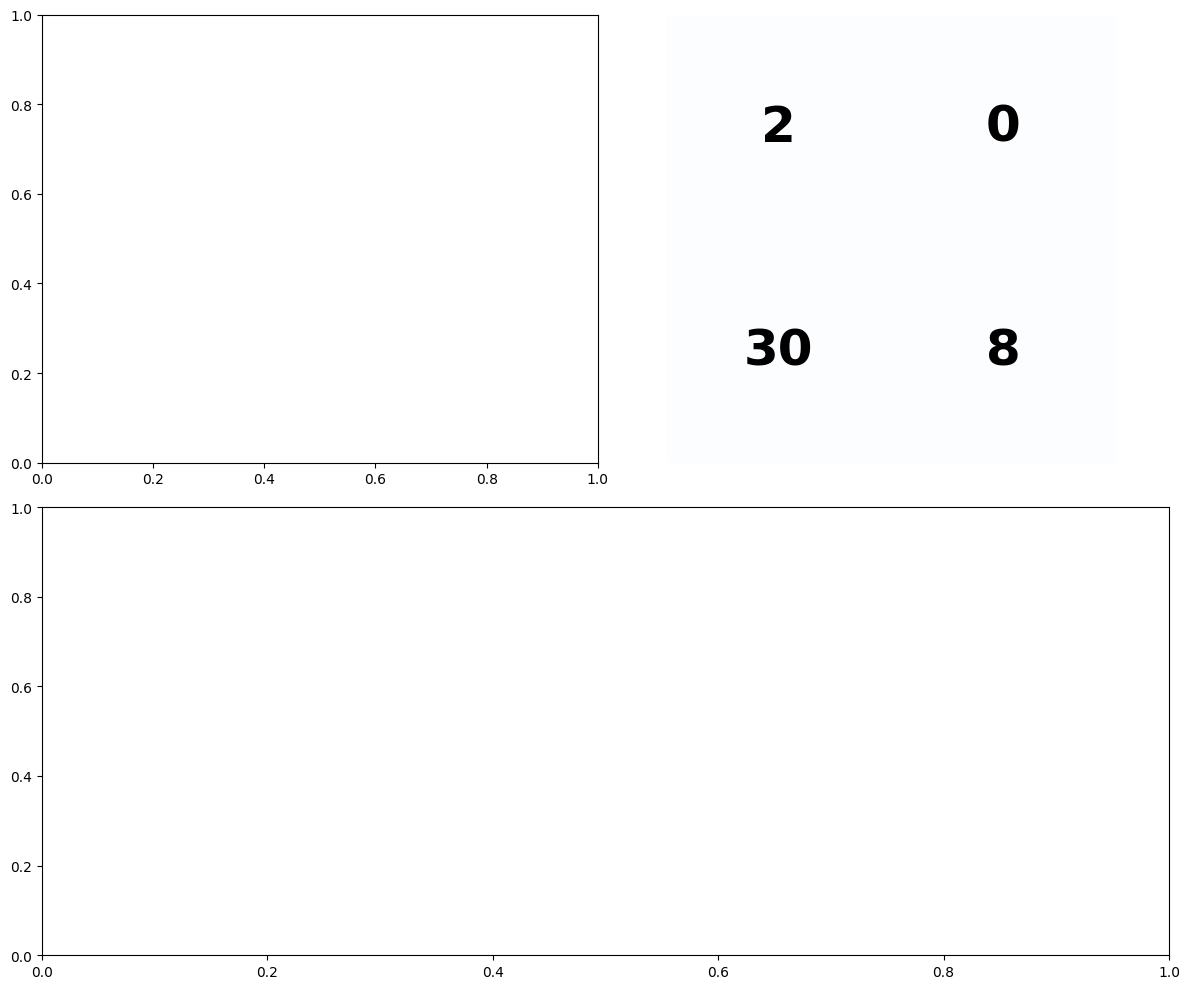

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

# Your data
A = np.array([[2, 30],[0, 8]])
end = np.array([[0, 0],[0, 0]])
start = np.array([[450, -250],[150, -50]])
B = np.array([[2, 0],[30, 8]])
C = np.array([[10, 15],[5, 20]])  # Third static matrix

# Generate interpolated list
num_iterations = 50
A_interpolated_lst = []

for i in range(num_iterations):
    t = i / (num_iterations - 1)
    distortion = (1 - t) * start + t * end
    A_current = A + distortion
    A_interpolated_lst.append(A_current)

# Target matrix (A + end distortion)
A_target = A + end

# Add 50 extra frames for 10 seconds of green (at 5fps)
total_frames = num_iterations + 50

# Create animation with custom layout
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2, 2, 1)  # Top-left: Matrix A
ax2 = plt.subplot(2, 2, 2)  # Top-right: Matrix B
ax3 = plt.subplot(2, 1, 2)  # Bottom: Matrix phi (spans entire row)

def animate(frame):
    # Clear animated subplots
    ax1.clear()
    ax3.clear()
    
    # Top-left: Animated convergence matrix A
    if frame < num_iterations:
        # Convergence phase - blend from red-blue to green
        A_current = A_interpolated_lst[frame]
        distance_matrix = A_current - A_target
        
        # Calculate progress (0 to 1)
        progress = frame / (num_iterations - 1)
        
        # Blend from red-blue to green across entire animation
        colors_rb = plt.cm.RdBu_r(np.linspace(0, 1, 256))
        colors_green = plt.cm.Greens(np.linspace(0, 1, 256))
        
        # Blend colors based on progress
        blended_colors = (1 - progress) * colors_rb + progress * colors_green
        custom_cmap = LinearSegmentedColormap.from_list('blend', blended_colors)
        
        im1 = ax1.imshow(distance_matrix, cmap=custom_cmap, aspect='equal')
            
    else:
        # Finished phase - keep same green as final convergence frame
        A_current = A_interpolated_lst[-1]
        distance_matrix = A_current - A_target
        
        # Use pure green colormap
        im1 = ax1.imshow(distance_matrix, cmap='Greens', aspect='equal', vmin=-1, vmax=1)
    
    # Add text annotations to animated matrix A
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            current_val = A_current[i, j]
            ax1.text(j, i, f'{current_val:.0f}', 
                   ha='center', va='center', fontsize=36, fontweight='bold', 
                   color='white')
    ax1.set_xticks([])
    ax1.set_yticks([])
    for spine in ax1.spines.values():
        spine.set_visible(False)

    
    # Bottom: Calculate and display phi matrix
    # A_prime = A_current, so we need to solve for phi based on constraints
    # For simplicity, let's calculate phi directly from the constraints
    A_prime = A_current
    
    # Initialize phi with zeros, then calculate based on constraints
    phi = np.zeros_like(A_prime) + 24
    
    # From constraint: A_prime[1:, :] - A_prime[:-1, :] == phi[1:, :] - phi[:-1, :]
    # This means: phi[1:, :] - phi[:-1, :] = A_prime[1:, :] - A_prime[:-1, :]
    # From constraint: B[:, 1:] - B[:, :-1] == phi[:, 1:] - phi[:, :-1]
    # This means: phi[:, 1:] - phi[:, :-1] = B[:, 1:] - B[:, :-1]
    
    # Simple calculation: integrate the differences
    for i in range(1, phi.shape[0]):
        phi[i, :] = phi[i-1, :] + (A_prime[i, :] - A_prime[i-1, :])
    
    for j in range(1, phi.shape[1]):
        phi[:, j] = phi[:, 0] + np.cumsum(B[:, 1:j+1] - B[:, :j], axis=1)[:, -1] 
    
    # Display phi matrix with same color scheme as A
    if frame < num_iterations:
        # Use same blended colormap as A
        im3 = ax3.imshow(phi, cmap=custom_cmap, aspect='equal')
        text_color = 'white'
    else:
        im3 = ax3.imshow(phi, cmap='Greens', aspect='equal', vmin=-10000, vmax=10000)
        text_color = 'white'  # White text on green background
    
    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            ax3.text(j, i, f'{phi[i,j]:.0f}', 
                   ha='center', va='center', fontsize=36, fontweight='bold', 
                   color=text_color)
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    for spine in ax3.spines.values():
        spine.set_visible(False)

def setup_static_matrices():
    # Top-right: Static matrix B
    im2 = ax2.imshow(np.zeros_like(B), cmap='Blues', aspect='equal', alpha=0.3)
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            ax2.text(j, i, f'{B[i,j]:.0f}', 
                   ha='center', va='center', fontsize=36, fontweight='bold', 
                   color='black')
    ax2.set_xticks([])
    ax2.set_yticks([])
    for spine in ax2.spines.values():
        spine.set_visible(False)

# Setup static matrices once
setup_static_matrices()

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=total_frames, 
                              interval=500, repeat=True)

plt.tight_layout()
plt.show()

# Save as gif (optional)
anim.save('matrix_convergence.gif', writer='pillow', fps=5)

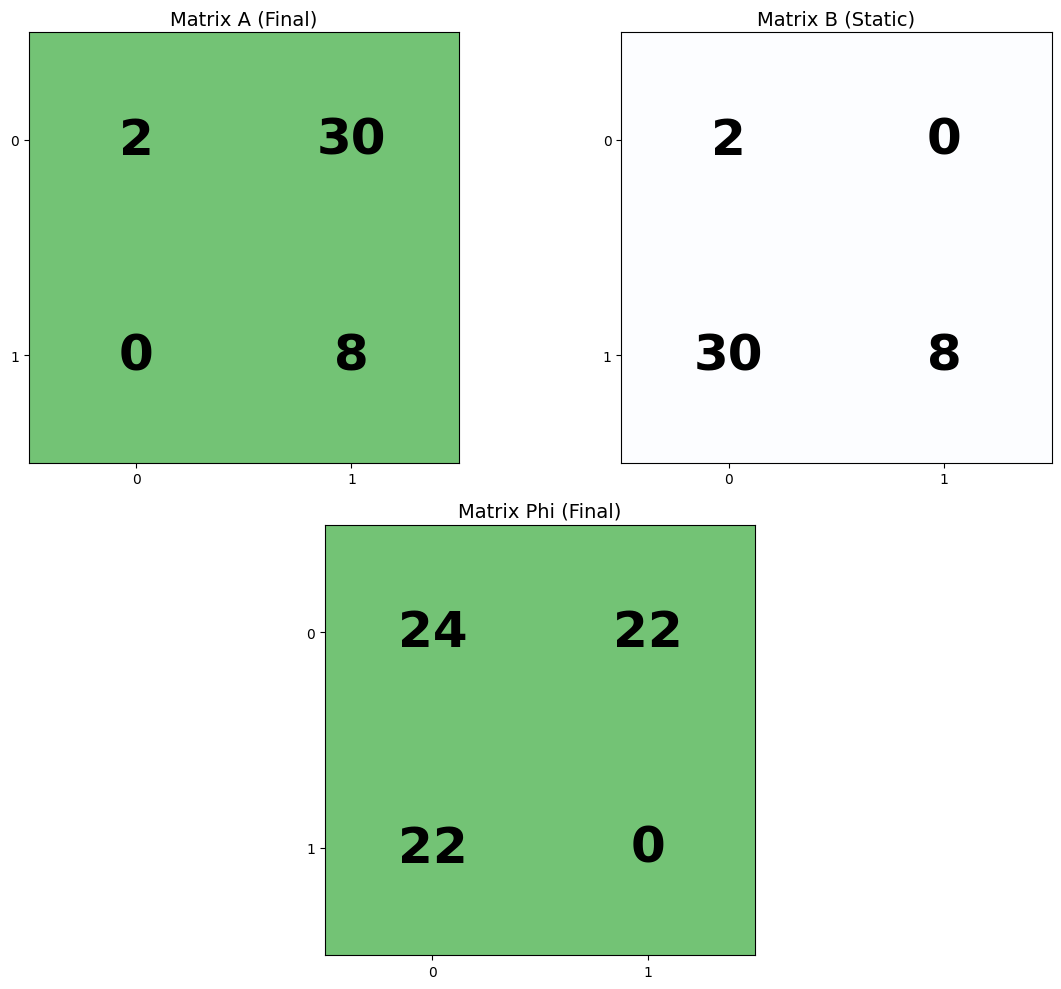

Final A matrix:
[[ 2 30]
 [ 0  8]]

Final phi matrix:
[[24 22]
 [22  0]]

Distance matrix (A - target):
[[0 0]
 [0 0]]


In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
A = np.array([[2, 30],[0, 8]])
end = np.array([[0, 0],[0, 0]])
start = np.array([[450, -250],[150, -50]])
B = np.array([[2, 0],[30, 8]])

# Final frame values
A_current = A + end  # Final A after convergence
A_target = A + end
distance_matrix = A_current - A_target

# Calculate final phi matrix
phi = np.zeros_like(A_current) + 24

# Apply the same calculations as in animation
for i in range(1, phi.shape[0]):
    phi[i, :] = phi[i-1, :] + (A_current[i, :] - A_current[i-1, :])

for j in range(1, phi.shape[1]):
    phi[:, j] = phi[:, 0] + np.cumsum(B[:, 1:j+1] - B[:, :j], axis=1)[:, -1]

# Create the plot with same layout as animation
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2, 2, 1)  # Top-left: Matrix A
ax2 = plt.subplot(2, 2, 2)  # Top-right: Matrix B
ax3 = plt.subplot(2, 1, 2)  # Bottom: Matrix phi

# Top-left: Final A matrix
im1 = ax1.imshow(distance_matrix, cmap='Greens', aspect='equal', vmin=-1, vmax=1)
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        current_val = A_current[i, j]
        ax1.text(j, i, f'{current_val:.0f}', 
               ha='center', va='center', fontsize=36, fontweight='bold', 
               color='black')
ax1.set_xticks(range(A_current.shape[1]))
ax1.set_yticks(range(A_current.shape[0]))
ax1.set_title('Matrix A (Final)', fontsize=14)

# Top-right: Static matrix B
im2 = ax2.imshow(np.zeros_like(B), cmap='Blues', aspect='equal', alpha=0.3)
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        ax2.text(j, i, f'{B[i,j]:.0f}', 
               ha='center', va='center', fontsize=36, fontweight='bold', 
               color='black')
ax2.set_xticks(range(B.shape[1]))
ax2.set_yticks(range(B.shape[0]))
ax2.set_title('Matrix B (Static)', fontsize=14)

# Bottom: Final phi matrix
im3 = ax3.imshow(phi, cmap='Greens', aspect='equal', vmin=-10000, vmax=10000)
for i in range(phi.shape[0]):
    for j in range(phi.shape[1]):
        ax3.text(j, i, f'{phi[i,j]:.0f}', 
               ha='center', va='center', fontsize=36, fontweight='bold', 
               color='black')
ax3.set_xticks(range(phi.shape[1]))
ax3.set_yticks(range(phi.shape[0]))
ax3.set_title('Matrix Phi (Final)', fontsize=14)

plt.tight_layout()
plt.show()

# Print the final values
print("Final A matrix:")
print(A_current)
print("\nFinal phi matrix:")
print(phi)
print("\nDistance matrix (A - target):")
print(distance_matrix)